In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dataset = 'classa'
rmin = 0.3
rmax = 0.8

In [3]:
# Read our results

import json

def combine_dict(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = combine_dict(dict1[key], dict2[key])
        else:
            dict1[key] = dict2[key]
    return dict1

def combine_dicts(dicts):
    u = None
    for d in dicts:
        if u is None:
            u = d
        else:
            u = combine_dict(u, d)
    return u

In [4]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE, BD_PSNR

In [5]:
from dataclasses import dataclass
from typing_extensions import TypeAlias, List, Dict
import numpy as np

@dataclass
class ResultUnit:
    r: float
    d: float
    t: float

ImageResults: TypeAlias = List[ResultUnit]

class DatasetResults:
    def __init__(self):
        self.img_results: Dict[str, ImageResults] = {}

    def update_image_result(self, img_name, r, d, t):
        self.img_results.setdefault(img_name, []).append(ResultUnit(r=r, d=d, t=t))

    def sort(self):
        for k in self.img_results.keys():
            self.img_results[k].sort(key=lambda x: x.r)

    @property
    def avg_r(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.r for x in rs]))
        return results

    @property
    def avg_d(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.d for x in rs]))
        return results

    @property
    def avg_t(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.t for x in rs]))
        return results

    def _bd_rate_imgwise(self, anchor, rng_anchor=None):
        self.sort()
        anchor.sort()
        if rng_anchor is not None:
            rng_anchor.sort()
        ans = {}
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)

            if rng_anchor is not None:
                rng_anchor_img = rng_anchor.img_results[filename]
                min_int = min([x.d for x in rng_anchor_img])
                max_int = max([x.d for x in rng_anchor_img])
                bd_rate = BD_RATE(R1, D1, R2, D2, min_int, max_int)
            else:
                bd_rate = BD_RATE(R1, D1, R2, D2)

            ans[filename] = bd_rate
        return ans

    def bd_rate(self, anchor, rng_anchor=None):
        ans = self._bd_rate_imgwise(anchor, rng_anchor)
        return np.mean(list(ans.values()))

    def bd_psnr(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)
            bd_rate = BD_PSNR(R1, D1, R2, D2)
            ans.append(bd_rate)
        return np.mean(ans)

    def time_saving(self, anchor):
        self.sort()
        anchor.sort()
        ans = []

In [6]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [7]:
import glob

results = glob.glob(f"{dataset}/*.json")

data_ours = combine_dicts([read_json(r) for r in results])

In [8]:
# speedups = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
speedups = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
qscales = [0.3, 0.4, 0.5, 0.6, 0.7]

In [9]:
data_ours['qscale=0.3'].keys()

dict_keys(['speedup=1.5', 'speedup=2.0', 'speedup=3.0', 'speedup=0.75', 'speedup=1.0', 'speedup=1.25', 'speedup=0.01', 'speedup=0.25', 'speedup=0.5'])

In [10]:
ours_results = {k: DatasetResults() for k in speedups}

for speedup in speedups:
    for qscale in qscales:
        glob_results = data_ours[f"qscale={qscale}"][f"speedup={speedup}"]
        for filename, result in glob_results.items():
            if filename[:3] != "avg":
                ours_results[speedup].update_image_result(
                    filename, result["bpp"], result["PSNR"], result["t_dec"]
                )

In [11]:
import pandas as pd

def read_xls(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

In [12]:
anchors = ['bpg', 'evc', 'jpeg', 'mlic', 'qarv', 'tcm', 'webp', 'vtm']

anchor_results: Dict[str, DatasetResults] = {k: DatasetResults() for k in anchors}

anchors_r = {}
anchors_d = {}
anchors_t = {}

for anchor in anchors:
    if anchor == 'vtm':
        xls_data: pd.DataFrame = read_xls(f"VTM.xls", dataset)
        filename = None
        for index, x in xls_data.iterrows():
            if isinstance(x.Filename, (str, int)) or (isinstance(x.Filename, float) and not np.isnan(x.Filename)):
                if isinstance(x.Filename, float):
                    filename = str(int(x.Filename))
                else:
                    filename = str(x.Filename)
            anchor_results[anchor].update_image_result(
                filename, x.bpp, x["RGB psnr"], x["Dec Time"] * 12.387
            )
    else:
        anchor_data = read_json(f"../../anchors/{dataset}/{anchor}/results.json")
        if anchor == 'bpg' and dataset == 'classa':
            for t1 in anchor_data.values():
                for t2 in t1.values():
                    for filename, result in t2.items():
                        if filename[:3] != "avg":
                            anchor_results[anchor].update_image_result(
                                filename, result["bpp"], result["PSNR"], result["t_dec"]
                            )
        else:
            for t2 in anchor_data.values():
                for filename, result in t2.items():
                    if filename[:3] != "avg":
                        anchor_results[anchor].update_image_result(
                            filename, result["bpp"], result["PSNR"], result["t_dec"]
                        )

In [13]:
import scipy


def interpolator(R, PSNR, min_r=None, max_r=None):
    lR = np.log(R)

    # integration interval
    min_int = min(PSNR)
    max_int = max(PSNR)

    lin = np.linspace(min_int, max_int, num=100, retstep=True)
    interval = lin[1]
    samples = lin[0]
    v = scipy.interpolate.pchip_interpolate(
        np.sort(PSNR), lR[np.argsort(PSNR)], samples
    )

    results = []
    for r, d in zip(np.exp(v), samples):
        results.append((r,d))
    return [x[0] for x in results], [x[1] for x in results]

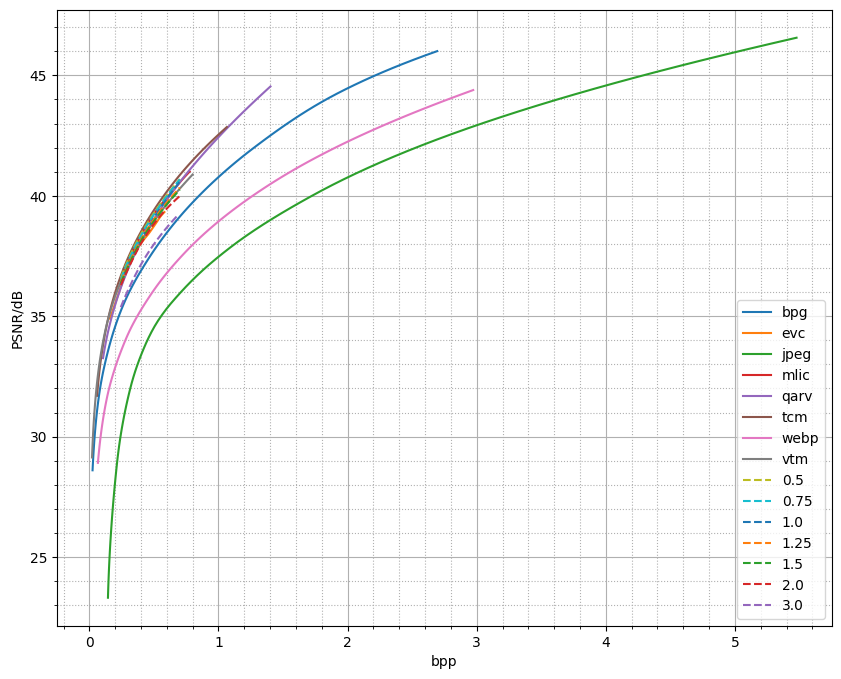

In [19]:
plt.figure(figsize=(10, 8))

for k, v in anchor_results.items():
    r = v.avg_r
    d = v.avg_d
    r, d = interpolator(r, d)
    plt.plot(r, d, label=k)

for speedup in speedups:
    r = ours_results[speedup].avg_r
    d = ours_results[speedup].avg_d
    r, d = interpolator(r, d)

    plt.plot(
        r,
        d,
        linestyle="--",
        label=speedup,
    )
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(28, 42)

plt.xlabel("bpp")
plt.ylabel("PSNR/dB")
plt.minorticks_on()
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle=":")

plt.show()

bpg 7.887459101279577 45.433867248039384
evc 2.78644299838278 10.488590573130212
jpeg 0.2819723703644492 399.0889530459972
mlic 29.449085375777 -3.3602474619078797
qarv 9.525865304650681 8.595418498292686
tcm 19.762631173487065 1.8833605696935258
webp 0.6669802954702667 161.46021841088643
vtm 14.958433939934753 0.0
0.5 16.189094525575637 -6.138399308451464
0.75 14.276456008354822 -5.2992601500387595
1.0 11.407557266950608 -1.2658238145388099
1.25 9.058871549367904 -0.47035358977823244
1.5 7.372443232933679 1.2755186878487637
2.0 5.283052531878154 4.638704716356261
3.0 3.7132100681463873 35.48907026563368


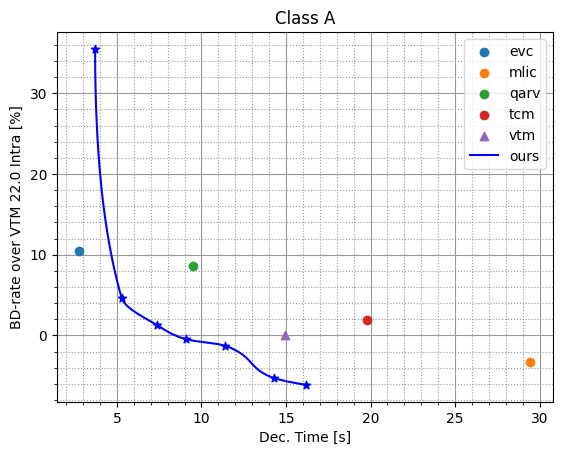

In [18]:
anchor = anchor_results['vtm']
rng_anchor = ours_results[0.5]

for k, v in anchor_results.items():
    bd = v.bd_rate(anchor)
    t = np.mean(v.avg_t)
    # r, d = interpolator(r, d)
    if k not in ['jpeg', 'bpg', 'webp']:
        marker = '^' if k == 'vtm' else 'o'
        plt.scatter(t, bd, label=k, zorder=10, marker=marker)
    if k == 'evc':
        evc_t, evc_bd = t, bd
    print(k, t, bd)

ours_bd = []
ours_t = []

for k, v in ours_results.items():
    bd = v.bd_rate(anchor)
    t = np.mean(v.avg_t)
    # if bd < evc_bd or t < evc_t:
    ours_bd.append(bd)
    ours_t.append(t)
    print(k, t, bd)

t, bd = interpolator(ours_t, ours_bd)

plt.plot(t, bd, label='ours', color='blue')
plt.scatter(ours_t, ours_bd, marker='*', color='blue', zorder=10)
plt.xlabel("Dec. Time [s]")
plt.ylabel("BD-rate over VTM 22.0 Intra [%]")
plt.minorticks_on()
plt.grid(zorder=0, which='major', color='#999999', linestyle='-')
plt.grid(zorder=0, which='minor', color='#999999', linestyle=':')
titles = {
    "classa": "Class A",
    "classb": "Class B",
    "classc": "Class C",
    "classd": "Kodak",
}
plt.title(titles[dataset])
plt.legend()

plt.savefig(f"{dataset}_performance_plot.pdf")
plt.savefig(f"{dataset}_performance_plot.png", dpi=600)

In [ ]:
import matplotlib as mpl

def plot_img_results(results: DatasetResults, anchor: DatasetResults, rng_anchor: DatasetResults = None):
    ans_results = results._bd_rate_imgwise(anchor, rng_anchor)
    ans_results = [(k, v) for k, v in ans_results.items()]
    ans_results.sort(key=lambda x: x[1])
    print(ans_results)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps['coolwarm']
    labels, values = zip(*ans_results)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis='y', zorder=0)
    plt.xticks(rotation=90)

In [ ]:
import matplotlib as mpl


def plot_img_results_comparison(
    results1: DatasetResults, results2, anchor: DatasetResults
):
    ans_results1 = results1._bd_rate_imgwise(anchor)
    ans_results2 = results2._bd_rate_imgwise(anchor)
    ans_results2 = [(k, ans_results1[k] - v) for k, v in ans_results2.items()]
    ans_results2.sort(key=lambda x: x[1])
    print(ans_results2)
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps["coolwarm"]
    labels, values = zip(*ans_results2)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis="y", zorder=0)
    plt.xticks(rotation=90)

[('IMG_8795', -32.013368840864544), ('IMG_3227', -26.55612189406016), ('DSC08936', -15.172666400631329), ('DSC08902', -13.065539555220784), ('IMG_3799', -10.546841763573967), ('IMG_4684', -8.525937123742233), ('IMG_3261', -8.412013676138052), ('DSC_3889', -7.871955284787703), ('IMG_1813', -7.654965616733489), ('DSC07099', -7.203201629365285), ('DSC08928', -6.796598714609525), ('DSC08626', -6.683237223527305), ('IMG_4700', -6.304347497256346), ('IMG_8176', -5.701352181050789), ('DOG_4507', -5.0317771144002705), ('DSC08796', -4.481580732851875), ('IMG_3412', -3.9944280501631226), ('DSC08672', -3.44153093911741), ('IMG_3515', -3.365994514064319), ('IMG_7136', -3.1650227343941175), ('DSC07705', -3.1048532282806143), ('IMG_6726', -2.73157056179486), ('DSC08892', -0.8206658665822042), ('DSC08582', 0.12333406773055167)]


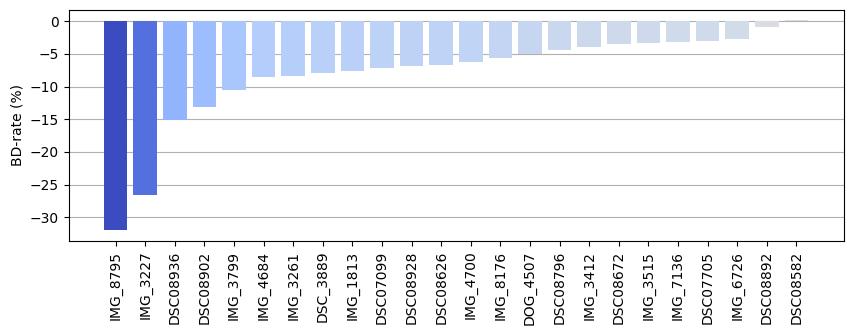

In [ ]:
plot_img_results_comparison(ours_results[0.5], anchor_results["tcm"], anchor_results["vtm"])
plt.savefig("ours_tcm_imgwise.pdf", bbox_inches="tight")
plt.savefig("ours_tcm_imgwise.png", dpi=600, bbox_inches="tight")

[('IMG_8795', -29.213283881423344), ('IMG_3227', -25.016113246217795), ('DSC08902', -18.795544482984397), ('IMG_3261', -17.30393020420933), ('DSC08936', -17.27366426803656), ('DSC08626', -13.216888259171624), ('IMG_3799', -12.097100576025843), ('IMG_6726', -8.392188058373973), ('DSC08892', -8.346840584870163), ('DSC08928', -8.296873476272292), ('IMG_8176', -7.992696129126253), ('DOG_4507', -7.83207271344164), ('IMG_3412', -7.010069473042224), ('IMG_3515', -6.740495496581467), ('IMG_1813', -6.724848099578551), ('DSC07099', -6.195325976639055), ('IMG_4684', -6.159369991857222), ('DSC_3889', -6.110158086937357), ('IMG_7136', -5.822164414187837), ('IMG_4700', -5.328146926724176), ('DSC08582', -3.5538540782202652), ('DSC08796', -3.53890090640141), ('DSC07705', -3.054207553907851), ('DSC08672', -2.65507862372526)]


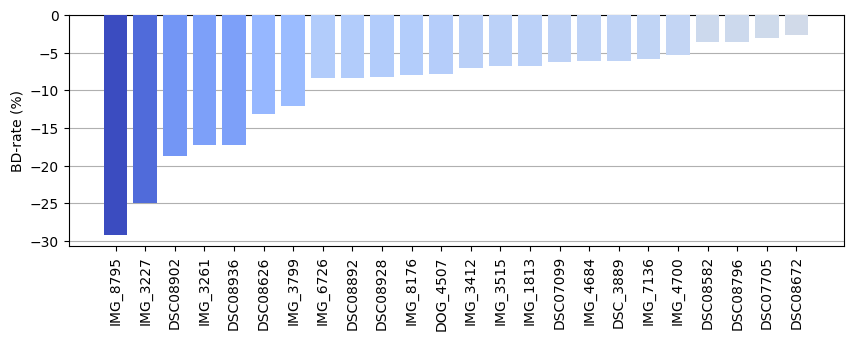

In [ ]:
plot_img_results_comparison(
    ours_results[1.0], anchor_results["qarv"], anchor_results["vtm"]
)
plt.savefig("ours_qarv_imgwise.pdf", bbox_inches='tight')
plt.savefig("ours_qarv_imgwise.png", dpi=600, bbox_inches="tight")

[('DSC08892', -12.800920248649751), ('IMG_8795', -11.789371491199471), ('DOG_4507', -11.153737706317425), ('IMG_8176', -8.498046999761797), ('DSC08626', -8.252516376630002), ('DSC08902', -8.090655382281643), ('IMG_3227', -7.930537095865042), ('IMG_1813', -7.58049777751748), ('IMG_3799', -7.12231459143805), ('DSC07099', -6.963278772471892), ('DSC08936', -6.709167797078398), ('DSC_3889', -6.123019605560676), ('IMG_6726', -5.106615629909839), ('DSC08928', -4.996736280108727), ('IMG_3261', -4.37204482658502), ('IMG_4684', -3.7967257979144686), ('IMG_4700', -3.67864750677378), ('IMG_3515', -3.600525428958401), ('DSC08582', -3.05763888489734), ('DSC08672', -2.789657833121373), ('DSC07705', -2.6723524192108883), ('IMG_3412', -2.416171362501185), ('IMG_7136', -1.82185437619178), ('DSC08796', 0.925773628369587)]


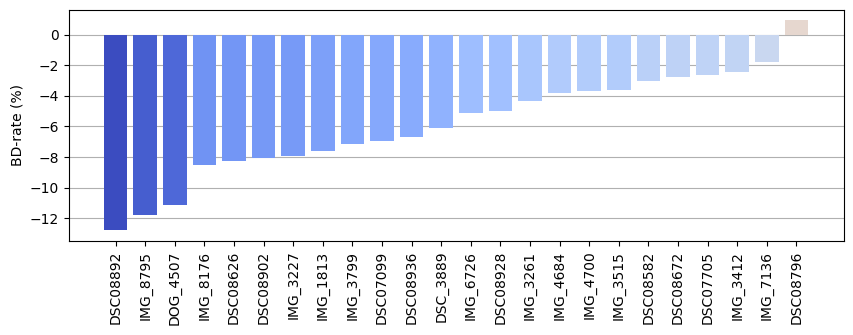

In [ ]:
plot_img_results_comparison(
    ours_results[2.0], anchor_results["evc"], anchor_results["vtm"]
)

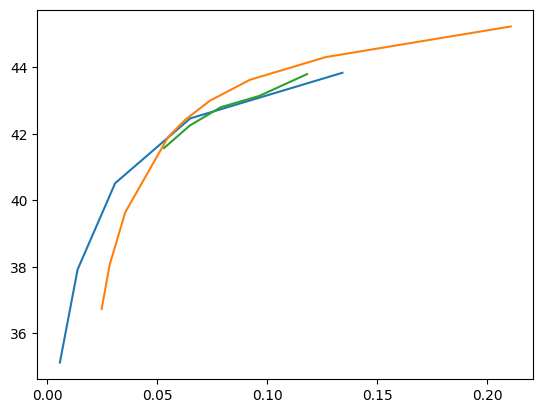

In [ ]:
def f(imgresult):
    plt.plot([x.r for x in imgresult], [x.d for x in imgresult])

f(anchor_results['vtm'].img_results['IMG_8795'])
f(anchor_results["tcm"].img_results["IMG_8795"])
f(ours_results[0.5].img_results["IMG_8795"])

[('IMG_3412', -9.863741165996432), ('DOG_4507', -8.62455611051206), ('DSC_3889', -8.239310976494718), ('DSC07705', -8.204346137806539), ('DSC08928', -7.813109065144575), ('IMG_3515', -7.5718195956893215), ('IMG_6726', -5.050747060082317), ('DSC08892', -4.83575774314422), ('IMG_4700', -4.729433655081994), ('DSC08672', -2.4861089837327155), ('IMG_4684', -1.9830000600721043), ('DSC08582', 0.7901861659374232), ('DSC08626', 1.2919284025389555), ('IMG_3799', 1.9118991404501795), ('DSC08796', 2.4025810993332897), ('IMG_1813', 2.6796449866937078), ('DSC07099', 3.716438014418255), ('DSC08936', 4.614617819039268), ('IMG_3261', 6.464947354151707), ('IMG_7136', 9.929593320790552), ('IMG_8176', 9.984795562167136), ('DSC08902', 11.560143460252558), ('IMG_3227', 21.03398175396416), ('IMG_8795', 38.221827146664424)]


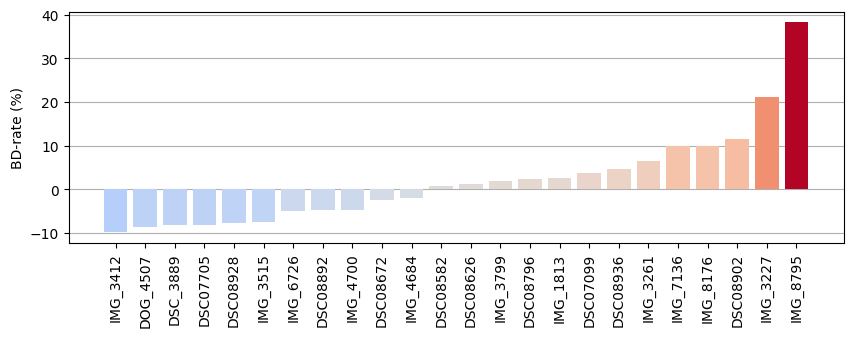

In [ ]:
plot_img_results(anchor_results['tcm'], anchor_results['vtm'], ours_results[0.5])

[('DSC_3889', -16.11126626128242), ('DSC08928', -14.6097077797541), ('IMG_3412', -13.858169216159554), ('DOG_4507', -13.65633322491233), ('DSC07705', -11.309199366087153), ('IMG_4700', -11.03378115233834), ('IMG_3515', -10.93781410975364), ('DSC08936', -10.558048581592061), ('IMG_4684', -10.508937183814338), ('IMG_3799', -8.634942623123788), ('IMG_6726', -7.782317621877177), ('DSC08672', -5.927639922850125), ('DSC08892', -5.656423609726424), ('IMG_3227', -5.522140140095999), ('DSC08626', -5.39130882098835), ('IMG_1813', -4.975320630039781), ('DSC07099', -3.4867636149470305), ('DSC08796', -2.0789996335185856), ('IMG_3261', -1.947066321986346), ('DSC08902', -1.5053960949682255), ('DSC08582', 0.9135202336679749), ('IMG_8176', 4.2834433811163475), ('IMG_8795', 6.20845830579988), ('IMG_7136', 6.7645705863964345)]


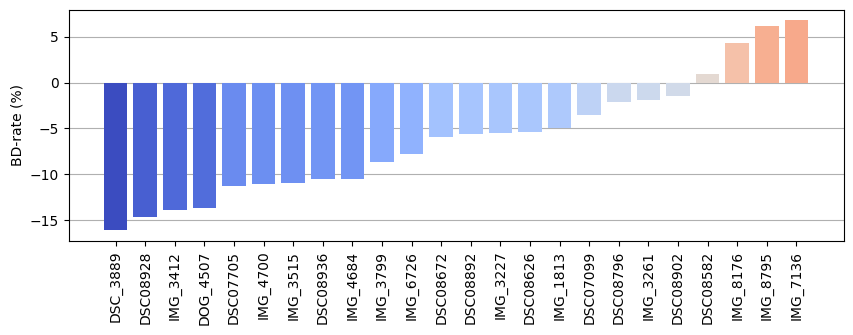

In [ ]:
plot_img_results(ours_results[0.5], anchor_results["vtm"])